# Try to detect null samples using reverse PCA

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from classification.classification import classify_all
from sklearn.preprocessing import StandardScaler
from preprocessing._chunk_preparation import concat_chunks_for_feature_extraction, preprocess_chunks_for_null_test_with_indoor
from preprocessing._segmentation import segment_for_null_classification
from visualization._visualization import pca_null_clf

from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

sample_rate = 50

# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 200
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Anne","Ariane","Cilly","Fabi","Julian","Julius","Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

selected_activities = ["washing hands", "drying hands"] # set to None if you want to classify between all activities

chunks, null_chunks, _ = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True, selected_activities=selected_activities)
chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size)

null_class_df, _ = concat_chunks_for_feature_extraction(
        [chunks_null_segmented],
        [labels_null_segmented])

# without null class
ocd_df, _ = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented])
assert len(set(labels_ocd_segmented)) == 1
assert len(set(labels_null_segmented)) == 1


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [2]:
X_ocd = extract_timeseries_features(ocd_df, use_indoor=use_indoor,use_fingerprinting_approach=True, feature_set_config=feature_calculation_setting)
X_null_class = extract_timeseries_features(null_class_df, use_indoor=use_indoor,use_fingerprinting_approach=True, feature_set_config=feature_calculation_setting)

scaler = StandardScaler()
scaler.fit(pd.concat([X_null_class, X_ocd]))
X_multi_class_classification_scaled = scaler.transform(X_ocd)
X_null_class_classification_scaled = scaler.transform(X_null_class)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


In [49]:
print(len(chunks_ocd_segmented))
print(len(chunks_null_segmented))

272
1816


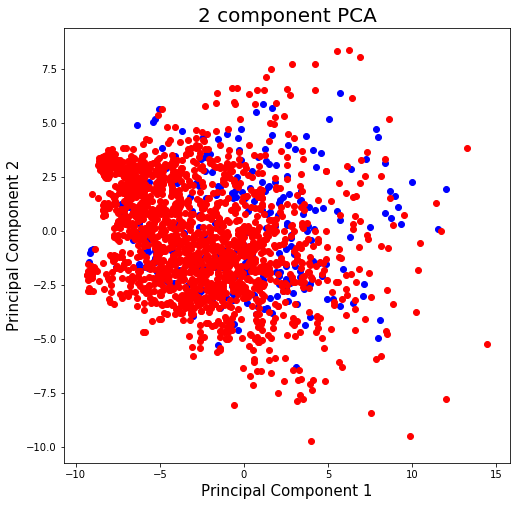

PCA variance
[0.27635658 0.10317998]


In [3]:
%matplotlib inline
pcs_ocd, pcs_null = pca_null_clf(X_multi_class_classification_scaled, X_null_class_classification_scaled, n_components=2)

In [54]:
len(pcs_ocd)

272

Multi class classification: using indoor: True; FC params: MinimalFCParameters; window_size 200
NB: 0.86 +/- 0.02
Logistic Regression: 0.87 +/- 0.01
CART: 0.78 +/- 0.04
LinearSVC: 0.87 +/- 0.00
SVC: 0.87 +/- 0.00
Random Forest: 0.84 +/- 0.02


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

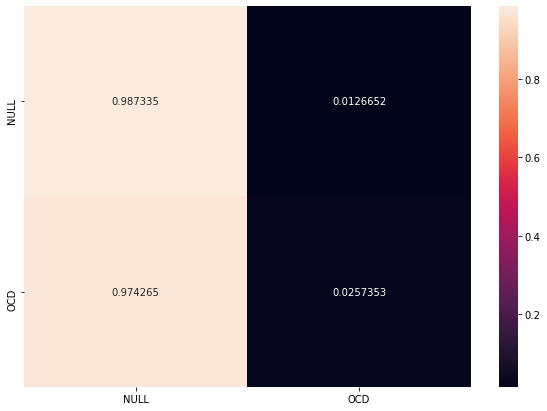

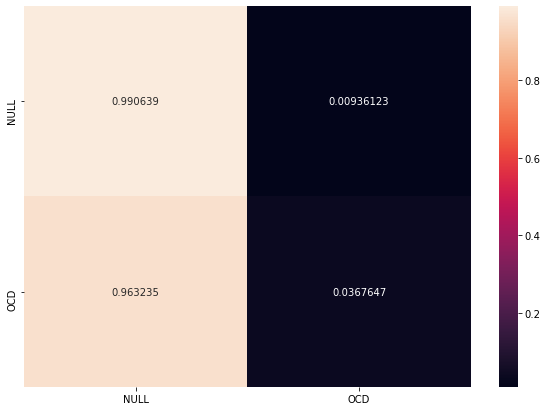

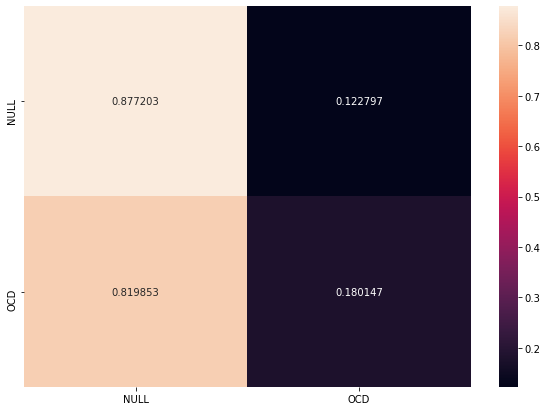

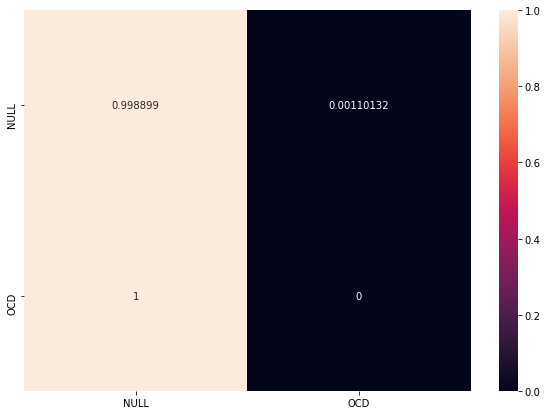

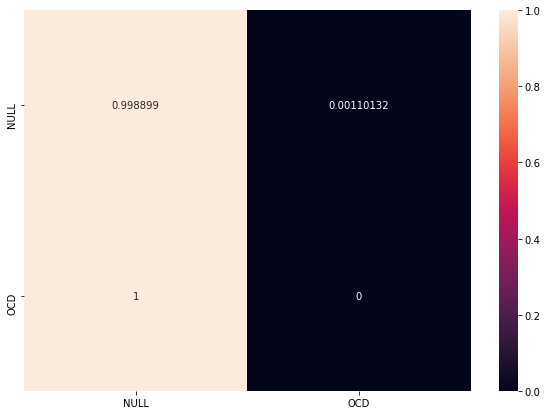

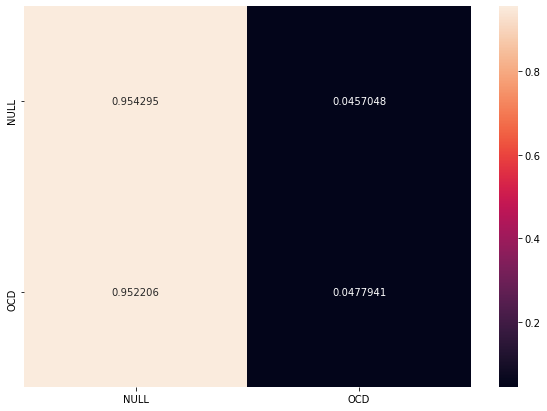

In [4]:
y = ["OCD"] * len(pcs_ocd) + ["NULL"] * len(pcs_null)
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(pd.concat([pd.DataFrame(pcs_ocd), pd.DataFrame(pcs_null)]), y, binary=True, path=None)

In [6]:
print(len(pcs_null)/len(y))